# Performance Analysis of various Visual Recognition services

## Goal

The goal for this notebook is to compare and contrast Watson Visual Recognition Service against our competititors - Google, Microsoft and Amazon.

### IBM Cloud - Watson

[Watson Developer Cloud](https://www.ibm.com/watsondevelopercloud) is a platform of cognitive services that leverage machine learning techniques to help partners and clients solve a variety of business problems. Furthermore, several of the WDC services fall under the **supervised learning** suite of machine learning algorithms, that is, algorithms that learn by example. This begs the questions: "How many examples should we provide?" and "When is my solution ready for prime time?"

[Watson Visual Recognition](https://www.ibm.com/watson/services/visual-recognition/)
A state of the art Visual Recognition Service from IBM Watson. Provide out of the box models as well as the ability to train custom models. 

### Microsoft Azure - Cognitive Services
[Microsoft Azure - Cognitive Services](https://azure.microsoft.com/en-us/services/cognitive-services/)

[Vision API/Custom Vision API](https://azure.microsoft.com/en-us/services/cognitive-services/directory/vision/)


## Google Cloud - Vision
[Google Cloud API](https://cloud.google.com/)
[Google Vision API](https://cloud.google.com/vision/)

<br> The notebook assumes you have already created a Watson [Visual Recognition](https://www.ibm.com/watson/developercloud/visual-recognition.html) instance and trained [custom classifiers](https://www.ibm.com/watson/developercloud/doc/visual-recognition/tutorial-custom-classifier.html). </br>
<br> To leverage this notebook, you need to provide the following information</br>
* Credentials for your Visual Recognition instance (apikey)
* id for your trained classifier (this is returned when you train your Visual Recognition custom classifier)
* csv file with your test images (paths to images on your local disk) and corresponding class labels
* results csv file to write the results to (true vs. predicted class labels)
* csv file to write confusion matrix to

Note that the input test csv file should have a header with the fields **image** and **class**. 

In [1]:
# Only run this the first time if pandas_ml is not installed on your machine
!pip install pandas_ml
# latest version of watson_developer_cloud (1.0.0) as of November 20, 2017
!pip install -I watson_developer_cloud==1.0.0
# previous version of watson_developer_cloud

#Install google vision client
!pip install google-api-python-client
!pip install --upgrade google-cloud-vision
!pip install --upgrade google-cloud

  Using cached requests-2.18.4-py2.py3-none-any.whl
  Using cached python_dateutil-2.6.1-py2.py3-none-any.whl
  Using cached pyOpenSSL-17.5.0-py2.py3-none-any.whl
  Using cached certifi-2018.1.18-py2.py3-none-any.whl
  Using cached urllib3-1.22-py2.py3-none-any.whl
  Using cached idna-2.6-py2.py3-none-any.whl
  Using cached chardet-3.0.4-py2.py3-none-any.whl
  Using cached six-1.11.0-py2.py3-none-any.whl
  Using cached cryptography-2.1.4-cp36-cp36m-macosx_10_6_intel.whl
  Using cached cffi-1.11.5-cp36-cp36m-macosx_10_6_intel.whl
  Using cached asn1crypto-0.24.0-py2.py3-none-any.whl
Exception:
Traceback (most recent call last):
  File "/Users/lkrishna/miniconda3/lib/python3.6/site-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/Users/lkrishna/miniconda3/lib/python3.6/site-packages/pip/commands/install.py", line 342, in run
    prefix=options.prefix_path,
  File "/Users/lkrishna/miniconda3/lib/python3.6/site-packages/pip/req/req_set.py", line

      Successfully uninstalled google-cloud-vision-0.29.0
Requirement already up-to-date: google-cloud in /Users/lkrishna/miniconda3/lib/python3.6/site-packages
Requirement already up-to-date: google-cloud-firestore<0.29dev,>=0.28.0 in /Users/lkrishna/miniconda3/lib/python3.6/site-packages (from google-cloud)
Requirement already up-to-date: google-cloud-logging<1.5dev,>=1.4.0 in /Users/lkrishna/miniconda3/lib/python3.6/site-packages (from google-cloud)
Requirement already up-to-date: google-cloud-resource-manager<0.29dev,>=0.28.0 in /Users/lkrishna/miniconda3/lib/python3.6/site-packages (from google-cloud)
Requirement already up-to-date: google-cloud-error-reporting<0.29dev,>=0.28.0 in /Users/lkrishna/miniconda3/lib/python3.6/site-packages (from google-cloud)
  Using cached google_cloud_vision-0.29.0-py2.py3-none-any.whl
Requirement already up-to-date: google-cloud-container<0.2dev,>=0.1.0 in /Users/lkrishna/miniconda3/lib/python3.6/site-packages (from google-cloud)
Requirement already

Requirement already up-to-date: chardet<3.1.0,>=3.0.2 in /Users/lkrishna/miniconda3/lib/python3.6/site-packages (from requests<3.0dev,>=2.18.4->google-cloud-vision<0.30dev,>=0.29.0->google-cloud)
Requirement already up-to-date: idna<2.7,>=2.5 in /Users/lkrishna/miniconda3/lib/python3.6/site-packages (from requests<3.0dev,>=2.18.4->google-cloud-vision<0.30dev,>=0.29.0->google-cloud)
Requirement already up-to-date: urllib3<1.23,>=1.21.1 in /Users/lkrishna/miniconda3/lib/python3.6/site-packages (from requests<3.0dev,>=2.18.4->google-cloud-vision<0.30dev,>=0.29.0->google-cloud)
Requirement already up-to-date: certifi>=2017.4.17 in /Users/lkrishna/miniconda3/lib/python3.6/site-packages (from requests<3.0dev,>=2.18.4->google-cloud-vision<0.30dev,>=0.29.0->google-cloud)
Requirement already up-to-date: proto-google-cloud-datastore-v1[grpc]<0.91dev,>=0.90.3 in /Users/lkrishna/miniconda3/lib/python3.6/site-packages (from gapic-google-cloud-datastore-v1<0.16dev,>=0.15.0->google-cloud-datastore<1.

In [13]:
#Import utilities
import json
import csv
import sys
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas_ml
import cv2
import numpy as np
import time 
import requests
import operator
from __future__ import print_function
import json
import csv
from pandas_ml import ConfusionMatrix
from watson_developer_cloud import VisualRecognitionV3
import itertools

#Google Vision
# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types

import matplotlib.pyplot as plt
%matplotlib inline 

Provide the path to the parms file which includes credentials to access your VR service as well as the input
test csv file and the output csv files to write the output results to.

In [81]:
# Sample parms file data
#{
#	"url": "https://gateway-a.watsonplatform.net/visual-recognition/api",
#	"apikey":"YOUR_VISUAL_RECOGNITION_APIKEY",
#	"vr_id":"YOUR_VISUAL_RECOGNITION_CUSTOM_CLASSIFIER_ID",
#	"test_csv_file": "COMPLETE_PATH_TO_YOUR_TEST_CSV_FILE",
#	"results_csv_file": "COMPLETE PATH TO RESULTS FILE (any file you can write to)",
#	"confmatrix_csv_file": "COMPLETE PATH TO CONFUSION MATRIX FILE (any file you can write to)"
#}

In [3]:
# Provide complete path to the file which includes all required parms
# A sample parms file is included (example_VR_parms.json)
vrParmsFile = '/Users/lkrishna/git/wdcutils/example_VR_parms.json'
parms = ''
with open(vrParmsFile) as parmFile:
    parms = json.load(parmFile)

url=parms['url']
apikey=parms['apikey']
vr_id=parms['vr_id']
test_csv_file=parms['test_csv_file']
results_csv_file=parms['results_csv_file']
confmatrix_csv_file=parms['confmatrix_csv_file']
base_folder=parms['base_folder']
json.dumps(parms)

# Variable for Azure - Custom Vision API
_region = 'southcentralus' #Here you enter the region of your subscription
_url = 'https://{}.api.cognitive.microsoft.com/customvision/v1.0/Prediction/dfe8d889-9861-4355-bd9a-866aa1de21a8/image'.format(_region)
_key = "8b215270f4a74852a876366b55fa33ca"
_maxNumRetries = 10

# Create an object for your Visual Recognition instance
visual_recognition = VisualRecognitionV3('2016-05-20', api_key=apikey)

Define useful methods to classify various APIs

In [32]:
# Given an image and a pointer to VR instance and classifierID, get back VR response
def getVRresponse(vr_instance,classifierID,image_path):
    with open(image_path, 'rb') as image_file:
        parameters = json.dumps({'threshold':0.01, 'classifier_ids': [classifierID]})
       #parameters = json.dumps({'threshold':0.01, 'classifier_ids': ['travel_1977348895','travel_2076475268','default']}) 
        image_results = vr_instance.classify(images_file=image_file,
                                             parameters = parameters)
        # For our purposes, we assume each call is to classify one image
        # Although the Visual Recognition classify endpoint accepts as input
        # a .zip file, we need each image to be labeled with the correct class
        classList = []
        for classifier in image_results['images'][0]['classifiers']:
            if classifier['classifier_id'] == vr_id:
                classList = classifier['classes']
                break
        # Sort the returned classes by score
        #print("classList: ", classList)
        sorted_classList = sorted(classList, key=lambda k: k.get('score', 0), reverse=True)
        #print("sortedList: ", sorted_classList)
    return sorted_classList

# Process multiple images (provided via csv file) in batch. Effectively, read the csv file and for each image
# utterance, get VR response. Aggregate and return results.
def batchVR(vr_instance,classifierID,csvfile):
    test_classes=[]
    vr_predict_classes=[]
    vr_predict_confidence=[]
    images=[]
    i=0
    with open(csvfile, 'r') as csvfile:
        csvReader=csv.DictReader(csvfile)
        for row in csvReader:
            test_classes.append(row['class'])
            vr_response = getVRresponse(vr_instance,classifierID,row['image'])
            vr_predict_classes.append(vr_response[0]['class'])
            vr_predict_confidence.append(vr_response[0]['score'])
            images.append(row['image'])
            i = i+1
            if(i%5 == 0):
                print("")
                print("Processed ", i, " images")
            if(i%10 == 0):
                sys.stdout.write('.')
        print("")
        print("Finished processing ", i, " images")
    return test_classes, vr_predict_classes, vr_predict_confidence, images

# Plot confusion matrix as an image
def plot_conf_matrix(conf_matrix):
    plt.figure()
    plt.imshow(conf_matrix)
    plt.show()

# Print confusion matrix to a csv file
def confmatrix2csv(conf_matrix,labels,csvfile):
    with open(csvfile, 'w') as csvfile:
        csvWriter = csv.writer(csvfile)
        row=list(labels)
        row.insert(0,"")
        csvWriter.writerow(row)
        for i in range(conf_matrix.shape[0]):
            row=list(conf_matrix[i])
            row.insert(0,labels[i])
            csvWriter.writerow(row)
            
# Returns precision, recall, F1 in DataFrame format     
def getPrecisionRecallF1Support(test_classes, predict_classes,_labels):
    clf_rep = precision_recall_fscore_support(test_classes, predict_classes,labels=_labels)
    out_dict = {
             "precision" :clf_rep[0].round(2)
            ,"recall" : clf_rep[1].round(2)
            ,"f1-score" : clf_rep[2].round(2)
            ,"support" : clf_rep[3]
            }
    out_df = pd.DataFrame(out_dict,index=labels)
    avg_tot = (out_df.apply(lambda x: round(x.mean(), 2) if x.name!="support" else  round(x.sum(), 2)).to_frame().T)
    avg_tot.index = ["avg/total"]
    out_df = out_df.append(avg_tot)
    return out_df

def getGoogleVisionResponse(image_path):
    

    # Pre-Req
    # export GOOGLE_APPLICATION_CREDENTIALS = /Path to Credentials JSON
    # Instantiates a client
    client = vision.ImageAnnotatorClient()

    # The name of the image file to annotate
    image_file = '/Users/lkrishna/Downloads/connectors/test-set/pc-vga.png'
    with open(image_path, 'rb') as image_file:
        content = image_file.read()

    image = types.Image(content=content)

    # Performs label detection on the image file
    response = client.label_detection(image=image)
    response_labels = response.label_annotations

    if response_labels is not None:
        return response_labels[0].description, round(response_labels[0].score,3)

# Process multiple images (provided via csv file) in batch. Effectively, read the csv file and for each image
# utterance, get VR response. Aggregate and return results.
def batchGoogleVision(csvfile):
    test_classes=[]
    predict_classes=[]
    predict_confidence=[]
    images=[]
    i=0
    with open(csvfile, 'r') as csvfile:
        csvReader=csv.DictReader(csvfile)
        for row in csvReader:
            test_classes.append(row['class'])
            label, score = getGoogleVisionResponse(row['image'])
            predict_classes.append(label)
            predict_confidence.append(score)
            images.append(row['image'])
            i = i+1
            if(i%5 == 0):
                print("")
                print("Processed ", i, " images")
            if(i%10 == 0):
                sys.stdout.write('.')
        print("")
        print("Finished processing ", i, " images")
    return test_classes, predict_classes, predict_confidence, images


def processAzureVisionRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json() ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )

        break
        
    return result

# Process multiple images (provided via csv file) in batch. Effectively, read the csv file and for each image
# utterance, get VR response. Aggregate and return results.
def batchAzureVisionRequest(csvfile):
    test_classes=[]
    predict_classes=[]
    predict_confidence=[]
    images=[]
    i=0

    # Computer Vision parameters
    params = { 'visualFeatures' : 'Color,Categories'} 

    headers = dict()
    headers['Ocp-Apim-Subscription-Key'] = _key
    headers['Content-Type'] = 'application/octet-stream'
    headers['Prediction-Key'] = _key

    json = None
    data = None
    
    with open(csvfile, 'r') as csvfile:
        csvReader=csv.DictReader(csvfile)
        for row in csvReader:
            test_classes.append(row['class'])
            
            pathToImageFile = row['image']
            with open( pathToImageFile, 'rb' ) as f:
                data = f.read()
            result = processAzureVisionRequest(json, data, headers, params)
            topClass = result['Predictions'][0]['Tag']
            topConfidence = result['Predictions'][0]['Probability']
            predict_classes.append(topClass)
            predict_confidence.append(topConfidence)
            images.append(row['image'])
            i = i+1
            if(i%5 == 0):
                print ("Processed ", i, " records")
        print ("Finished processing ", i, " records")      
    return test_classes, predict_classes,predict_confidence, images


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## IBM Cloud - Watson Visual Recognition API

### Pre-Requisite

This set of notebook scripts assumes that you have created and trained a custom classifier using Watson Visual Recognition Service and possess an API Key

In [5]:
# List of all custom classifiers in your visual recognition service
print(json.dumps(visual_recognition.list_classifiers(), indent=2))

{
  "classifiers": [
    {
      "classifier_id": "faulty_devices_1673101197",
      "name": "faulty_devices",
      "status": "ready"
    },
    {
      "classifier_id": "connectors_1834282634",
      "name": "connectors",
      "status": "ready"
    },
    {
      "classifier_id": "Dinosaurs_1759706961",
      "name": "Dinosaurs",
      "status": "ready"
    },
    {
      "classifier_id": "Shelf_Classifier_900949333",
      "name": "Shelf_Classifier",
      "status": "ready"
    },
    {
      "classifier_id": "ConnectorsxAll_296574083",
      "name": "Connectors-All",
      "status": "ready"
    }
  ]
}


[
  {
    "class": "vga_female",
    "score": 0.998919
  },
  {
    "class": "usb_female",
    "score": 0.656776
  },
  {
    "class": "usbc_female",
    "score": 0.610961
  }
]


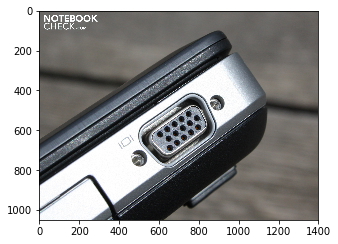

In [16]:
# This is an optional step to quickly test response from Visual Recognition for a given image
pathToFileInDisk=r'/Users/lkrishna/Downloads/connectors/test-set/Latitude_E5420_56.jpg'

with open( pathToFileInDisk, 'rb' ) as f:
    data = f.read()
    
##classifierList = "'" + vr_id + "'" + "," + "'" + "default" + "'"
result = getVRresponse(visual_recognition,vr_id,pathToFileInDisk)

if result is not None:
    # Load the original image, fetched from the URL
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )
    ig, ax = plt.subplots(figsize=(5, 10))
    ax.imshow( img )
print(json.dumps(result[:3], indent=2))

Call Visual Recognition on the specified csv file and collect results.

In [18]:
test_classes,vr_predict_classes,vr_predict_conf,images=batchVR(visual_recognition,vr_id,test_csv_file)


Processed  5  images

Processed  10  images
.
Finished processing  10  images


In [19]:
# print results to csv file including original text, the correct label, 
# the predicted label and the confidence reported by NLC.
csvfileOut=results_csv_file
with open(csvfileOut, 'w') as csvOut:
    outrow=['image','true class','VR Predicted class','Confidence']
    csvWriter = csv.writer(csvOut,dialect='excel')
    csvWriter.writerow(outrow)
    for i in range(len(images)):
        outrow=[images[i],test_classes[i],vr_predict_classes[i],str(vr_predict_conf[i])]
        csvWriter.writerow(outrow)

In [20]:
# Compute confusion matrix for VR
labels=list(set(test_classes))
vr_confusion_matrix = confusion_matrix(test_classes, vr_predict_classes, labels)
vrConfMatrix = ConfusionMatrix(test_classes, vr_predict_classes)

In [21]:
# Print out confusion matrix with labels to csv file
confmatrix2csv(vr_confusion_matrix,labels,confmatrix_csv_file)

Normalized confusion matrix
[[ 1.   0.   0.   0. ]
 [ 0.   1.   0.   0. ]
 [ 0.   0.5  0.5  0. ]
 [ 0.   0.   0.   1. ]]


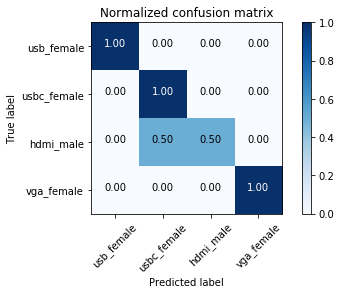

In [22]:
%matplotlib inline
#vrConfMatrix.plot()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(vr_confusion_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [23]:
# Compute accuracy of classification
acc=accuracy_score(test_classes, vr_predict_classes)
print('Classification Accuracy: ', acc)

Classification Accuracy:  0.9


In [24]:
# print precision, recall and f1-scores for the different classes
print ("Watson VR - Custom Model Results")
print (getPrecisionRecallF1Support(test_classes, vr_predict_classes,labels))

Watson VR - Custom Model Results
             f1-score  precision  recall  support
usb_female       1.00       1.00    1.00      2.0
usbc_female      0.80       0.67    1.00      2.0
hdmi_male        0.67       1.00    0.50      2.0
vga_female       1.00       1.00    1.00      4.0
avg/total        0.87       0.92    0.88     10.0


## Microsoft Azure Vision - Tests

Top Tag : vga_female
Top Tag Probability:  1.0


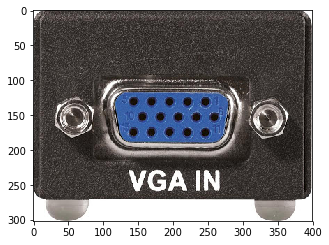

In [26]:
# Load raw image file into memory
pathToFileInDisk = r'/Users/lkrishna/Downloads/connectors/test-set/computer-hardware-VGA-FEMALE.JPG'
with open( pathToFileInDisk, 'rb' ) as f:
    data = f.read()
    
# Computer Vision parameters
params = { 'visualFeatures' : 'Color,Categories,Tags'} 

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'
headers['Prediction-Key'] = _key

json = None

result = processAzureVisionRequest( json, data, headers, params )

if result is not None:
    # Load the original image, fetched from the URL
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )

    ig, ax = plt.subplots(figsize=(5, 10))
    ax.imshow( img )
    print ("Top Tag : " + result['Predictions'][0]['Tag'])
    print ("Top Tag Probability: " , result['Predictions'][0]['Probability'])

In [27]:
# print results to csv file including original text, the correct label, 

test_classes,azure_predict_classes,azure_predict_conf,images=batchAzureVisionRequest(test_csv_file)
results_csv_file="/Azure-vision-test-results.csv"
csvfileOut=base_folder + results_csv_file
with open(csvfileOut, 'w') as csvOut:
    outrow=['image','true class','VR Predicted class','Confidence']
    csvWriter = csv.writer(csvOut,dialect='excel')
    csvWriter.writerow(outrow)
    for i in range(len(images)):
        outrow=[images[i],test_classes[i],azure_predict_classes[i],str(azure_predict_conf[i])]
        csvWriter.writerow(outrow)

Message: {'statusCode': 429, 'message': 'Rate limit is exceeded. Try again in 1 seconds.'}
Processed  5  records
Processed  10  records
Finished processing  10  records


In [102]:
# Compute accuracy of classification
acc=accuracy_score(test_classes, azure_predict_classes)
print('Classification Accuracy (Azure Custom Vision API) : ', acc)

Classification Accuracy (Azure Custom Vision API) :  0.470588235294


In [28]:
# print precision, recall and f1-scores for the different classes
print ("Microsoft Custom Vision API - Results")
print (getPrecisionRecallF1Support(test_classes, azure_predict_classes,labels))

Microsoft Custom Vision API - Results
             f1-score  precision  recall  support
usb_female        1.0        1.0     1.0      2.0
usbc_female       1.0        1.0     1.0      2.0
hdmi_male         1.0        1.0     1.0      2.0
vga_female        1.0        1.0     1.0      4.0
avg/total         1.0        1.0     1.0     10.0


Predicted    hdmi_male  usb_female  usbc_female  vga_female  __all__
Actual                                                              
hdmi_male            2           0            0           0        2
usb_female           0           2            0           0        2
usbc_female          0           0            2           0        2
vga_female           0           0            0           4        4
__all__              2           2            2           4       10
Normalized confusion matrix
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


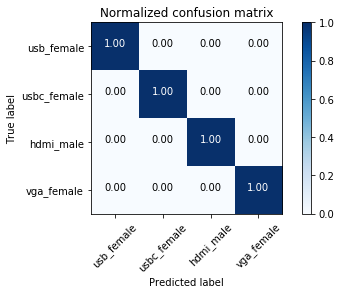

In [30]:
# Compute & plot confusion matrix for Azure Vision API
labels=list(set(test_classes))
azure_confusion_matrix = confusion_matrix(test_classes, azure_predict_classes, labels)
azureConfMatrix = ConfusionMatrix(test_classes, azure_predict_classes)
print (azureConfMatrix)

%matplotlib inline
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(azure_confusion_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

## Google Vision API - Tests

In [33]:
import io
import os

# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types

# Instantiates a client
client = vision.ImageAnnotatorClient()

# The name of the image file to annotate
file_name = '/Users/lkrishna/Downloads/connectors/test-set/pc-vga.png'

# Loads the image into memory
with io.open(file_name, 'rb') as image_file:
    content = image_file.read()

image = types.Image(content=content)

# Performs label detection on the image file
response = client.label_detection(image=image)
response_labels = response.label_annotations

print('Labels:')
for label in response_labels:
    print(label.description + "("  + repr(round(label.score,2)) + ")")

DefaultCredentialsError: Could not automatically determine credentials. Please set GOOGLE_APPLICATION_CREDENTIALS or
explicitly create credential and re-run the application. For more
information, please see
https://developers.google.com/accounts/docs/application-default-credentials.

In [106]:
# print results to csv file including original text, the correct label, 

test_classes,predict_classes,predict_conf,images=batchGoogleVision(test_csv_file)
results_csv_file="/Google-vision-test-results.csv"
csvfileOut=base_folder + results_csv_file
with open(csvfileOut, 'w') as csvOut:
    outrow=['image','true class','VR Predicted class','Confidence']
    csvWriter = csv.writer(csvOut,dialect='excel')
    csvWriter.writerow(outrow)
    for i in range(len(images)):
        outrow=[images[i],test_classes[i],predict_classes[i],str(predict_conf[i])]
        csvWriter.writerow(outrow)


Processed  5  images

Processed  10  images
.
Processed  15  images

Finished processing  17  images


In [107]:
# Compute accuracy of classification
acc=accuracy_score(test_classes, predict_classes)
print('Classification Accuracy: ', acc)

Classification Accuracy:  0.0


In [108]:
# print precision, recall and f1-scores for the different classes
print ("Google Vision - Results")
print (getPrecisionRecallF1Support(test_classes, predict_classes,labels))

Google Vision - Results
                  f1-score  precision  recall  support
hdmi_female            0.0        0.0     0.0      1.0
usbc_male              0.0        0.0     0.0      1.0
vga_male               0.0        0.0     0.0      3.0
thunderbolt_male       0.0        0.0     0.0      3.0
hdmi_male              0.0        0.0     0.0      3.0
vga_female             0.0        0.0     0.0      1.0
usb_male               0.0        0.0     0.0      2.0
frayed_faulty          0.0        0.0     0.0      3.0
avg/total              0.0        0.0     0.0     17.0


/Users/lkrishna/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [109]:
# Compute confusion matrix for VR
labels=list(set(test_classes))
google_confusion_matrix = confusion_matrix(test_classes, predict_classes, labels)
googleConfMatrix = ConfusionMatrix(test_classes, predict_classes)

/Users/lkrishna/miniconda3/lib/python3.6/site-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


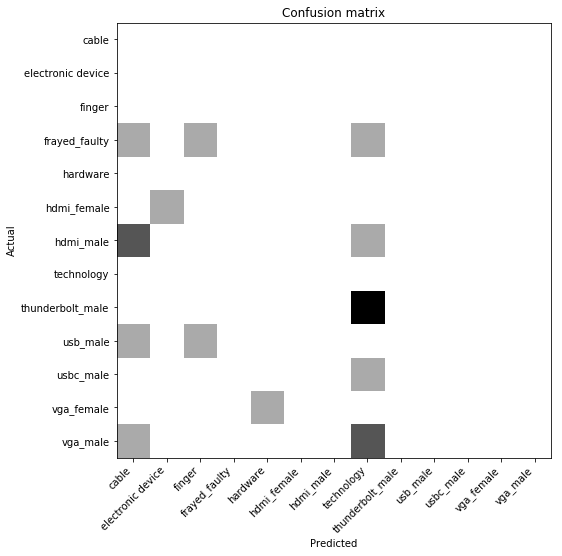

In [110]:
%matplotlib inline
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(google_confusion_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix')